In [1]:
from lale.datasets.uci.uci_datasets import fetch_drugscom
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import lale.schema2enums
import logging
lale.schema2enums.logger.setLevel(logging.ERROR)
train_X_all, train_y_all, test_X, test_y = fetch_drugscom()
#subset 3% = 4,838 rows to speed up experimentation
train_X, train_X_ignore, train_y, train_y_ignore = train_test_split(
    train_X_all, train_y_all, train_size=0.03, random_state=42)
print(f'shapes: train_X {train_X.shape}, test_X {test_X.shape}')
train_X.head()

shapes: train_X (4838, 5), test_X (53766, 5)


,drugName,condition,review,date,usefulCount
3969,Citalopram,Depression,"""Celexa is a literally a magic pill, for me. 2...","December 8, 2014",48
4926,Prevacid,GERD,"""I have tried almost every acid reducer made i...","January 16, 2016",33
80152,Aubra,Birth Control,"""I hate this pill, extreme depression, breast ...","December 4, 2016",5
79507,Microgestin Fe 1.5 / 30,Abnormal Uterine Bleeding,"""I had been on my period for 3months. The micr...","June 27, 2016",6
130035,Azurette,Birth Control,"""Effective at preventing pregnancy. My skin wa...","October 14, 2013",19


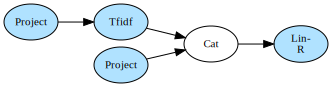

In [2]:
from lale.lib.lale import Project
from lale.lib.lale import ConcatFeatures as Cat
from lale.lib.sklearn import TfidfVectorizer as Tfidf
from lale.lib.sklearn import LinearRegression as LinR
from lale.helpers import to_graphviz
trainable = (
        Project(columns=['review']) >> Tfidf(max_features=100)
      & Project(columns={'type': 'number'})
    ) >> Cat >> LinR()
to_graphviz(trainable)

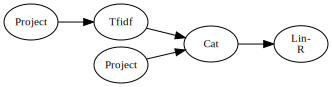

In [3]:
trained = trainable.fit(train_X, train_y)
predicted = trained.predict(test_X)
to_graphviz(trained)

In [4]:
import math
from sklearn.metrics import mean_squared_error
comparisons = [f'{int(test_y[i])}:{predicted[i]:.1f}' for i in range(10)]
print(f'comparisons [{", ".join(comparisons)}]')
rmse = math.sqrt(mean_squared_error(predicted, test_y))
print(f'RMSE {rmse:.2f}')

comparisons [10:7.8, 8:9.1, 9:5.7, 9:7.4, 9:5.8, 4:7.6, 6:5.4, 9:8.4, 7:5.9, 2:6.5]
RMSE 3.00


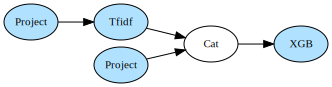

In [5]:
from lale.lib.xgboost import XGBRegressor as XGB
trainable = (
        Project(columns=['review']) >> Tfidf(max_features=100)
      & Project(columns={'type': 'number'})
    ) >> Cat >> XGB()
to_graphviz(trainable)

In [6]:
trained = trainable.fit(train_X, train_y)
predicted = trained.predict(test_X)
comparisons = [f'{int(test_y[i])}:{predicted[i]:.1f}' for i in range(10)]
print(f'comparisons [{", ".join(comparisons)}]')
rmse = math.sqrt(mean_squared_error(predicted, test_y))
print(f'RMSE {rmse:.2f}')

comparisons [10:8.2, 8:7.8, 9:4.8, 9:7.4, 9:4.7, 4:7.1, 6:4.1, 9:7.4, 7:6.8, 2:6.2]
RMSE 2.98


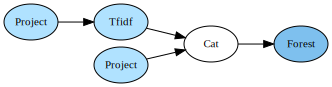

In [7]:
from lale.lib.sklearn import RandomForestRegressor as Forest
tfidf_hps = {**Tfidf.hyperparam_defaults(), 'max_features': 100, 'ngram_range': (1,1)}
planned = (
        Project(columns=['review']) >> Tfidf(**tfidf_hps)
      & Project(columns={'type': 'number'})
    ) >> Cat >> Forest
to_graphviz(planned)

100%|██████████| 3/3 [01:20<00:00, 26.85s/it, best loss: -0.10722638786376278]
RMSE 3.11


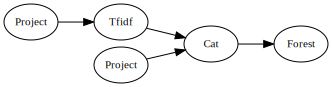

In [8]:
from lale.lib.lale import Hyperopt
best_estimator = planned.auto_configure(train_X, train_y, optimizer=Hyperopt, max_evals=3, scoring='r2')
predicted = best_estimator.predict(test_X)
rmse = math.sqrt(mean_squared_error(predicted, test_y))
print(f'RMSE {rmse:.2f}')
to_graphviz(best_estimator)

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


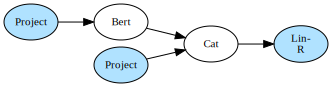

In [9]:
from lale.lib.lale import Project
from lale.lib.pytorch import BertPretrainedEncoder as Bert
from lale.lib.lale import ConcatFeatures as Cat
from lale.lib.sklearn import LinearRegression as LinR
trainable = (
        Project(columns=['review']) >> Bert(batch_size=126)
      & Project(columns={'type': 'number'})
    ) >> Cat >> LinR()
to_graphviz(trainable)

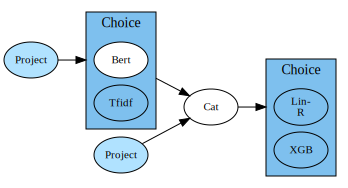

In [10]:
from lale.lib.lale import Project
from lale.lib.sklearn import TfidfVectorizer as Tfidf
from lale.lib.pytorch import BertPretrainedEncoder as Bert
from lale.lib.lale import ConcatFeatures as Cat
from lale.lib.sklearn import LinearRegression as LinR
from lale.lib.xgboost import XGBRegressor as XGB
planned = (
        Project(columns=['review']) >> (Bert | Tfidf)
      & Project(columns={'type': 'number'})
    ) >> Cat >> (LinR | XGB)
to_graphviz(planned)